# Coursework 2: Robotic behavioural cloning from images and actuator data

## Description
For this coursework, you are required to develop a behaviour cloning model. Behaviour cloning is a technique for training robotic agents using a dataset of sequences of actions. Consider the supervised learning definition where we have a dataset of observatios $d=\{(x_{1},y_{1}),...,(x_{n},y_{n})\}$ and the aim is to learn a function: $f:\mathcal{X}\rightarrow\mathcal{Y}$. In this case, $\mathcal{X}$ is the set of "observations" that the robot makes and $\mathcal{Y}$ is the set of actions that the robot takes.

The dataset you have been provided with contains examples of robot arms being required to pickup objects or drop objects (given it has already picked the object up) in a specific place. The observation space ($\mathcal{X}$) consists of:
- "front_cam_ob": A 3rd person image of the scene 
- "mount_cam_ob": An image of the scene taken from a camera mounted on top of the robotic arm, looking down
- "ee_cartesian_pos_ob": The positional and orientation co-ordinates of the robotic arm
- "ee_cartesian_vel_ob": The velocity of position and orientation of the robotic arm
- "joint_pos_ob": The position of the gripper which opens and closes

The action space ($\mathcal{Y}$) consists of:
- Three co-ordinates defining how much to move the robotic arm
- An action defining whether to open, not to move or close the gripper

The dataset is split into "trajectories" i.e., sequences of:
- $x_{i}$: The front_cam_ob, mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob, joint_pos_ob __at time point i__ 
- $y_{i}$: The action taken i.e., how to move the arm and the gripper __given the observations__ in $x_{i}$

More information on the dataset can be found at: https://github.com/clvrai/clvr_jaco_play_dataset?tab=readme-ov-file

### Task
Your task has been split into several questions, each exploring how to develop an appropriate model for learning $f:\mathcal{X}\rightarrow\mathcal{Y}$. The task will require you to:
- Question 1: Tune an end-to-end supervised learning model taking in the full set of observations and predicting actions: You will be required to evaluate a proposed deep learning architecture (which takes as input all of front_cam_ob, mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob and joint_pos_ob and predict the two actions) and propose a new model which outperforms the existing model;
- Question 2: Define and evaluate a VAE model for performing self-supervised learning and tune it as best you can, to learn a latent representation that can be used as input to a downstream supervised model for behaviour cloning
- Question 3: Evaluate the performance of your model proposed in question 1 against your self-supervised VAE representations from question 2 (plus a supervised head) on the test set

### Pointers
Some helper functions have been provided for you including the following functionality:
- A training and validation loop capabale of:
  - Handling "half-precision" modelling;
  - Logging results to weights and biases;
- An eda template to help you visualise the data
- An evaluation template to help you load saved model checkpoints from weights and biases
- A preprocessing script to help you convert the data into train/validation and test splits;
  - In this preprocessing script, trajectories longer than 75 timesteps have been removed to ease the computational requirements of the task;
- A torch Dataset class capable of handling the multi-model nature of the data;
- A example collate_fn to use in Dataloaders

Additionally, it is strongly suggested to call ```torch.manual_seed(1)``` whenever you initialise your model (i.e., when you first create the model or call model.reset()). This will ensure the parameters are initialised at the same value each time.

### IMPORTANT
- You are __not__ allowed to use pre-trained models, developed outside of this coursework i.e., you could __not__ use a pre-trained YOLO model
- Questions have been marked under the title "Task", ensure that you answer/address all of the bullet points under these headings


## Data download
Download the data for the project from here: https://drive.usercontent.google.com/download?id=1tVSilmXhyQd8gxZAEhvKMnynw0qzRFSZ&authuser=0

Save the data locally at: ../data/all_play_data_diverse or in Google Collab at: /content/drive/MyDrive/comp0188_2425/cw2. Saving the data in these locations will ensure the proprocessing script provided runs correctly. If you would like to alter these locations, you can alter them in the config.py file of the provided comp0188_cw2 package via the ROOT_PATH global variable.

### transition_df.csv
You have additionally been provided with a csv called "transition_df.csv". This contains a row for each observation/action pair in the dataset and is used to generate the train/validation and test datasets for this task. Note that this csv contains all trajectories (even those over 75 timesteps). This csv might also be useful for EDA. The transition_df.csv should be placed in the same folder that you placed the raw data in (discussed above).

## Imports

The comp0188_cw2 contains some config functionality so that you can run the code in collab and locally (to test models)! When you first import the package, import the project_options and set the appropriate configs.
- project_options.collab = True will set the dataset directories for google collab whilst false will set suitable local directories
- project_options.debug = True will load a subset of data whilst False will load all of the data. 

__IMPORTANT__: Alterting these options __once you have loaded other functionality__ from comp0188_cw2 may result in unintended outcomes.

In [1]:
# COLLAB = False
# if COLLAB:
#     !pip install --force-reinstall git+https://github.com/joshuaspear/pymlrf.git
#     !pip install h5py
#     # !pip install wandb
#     !pip install torchinfo
#     !pip install jaxtyping
#     !pip install git+https://github.com/joshuaspear/comp0188_cw2_public.git
#     !pip install typeguard==2.13.3

In [2]:
# !pip install --force-reinstall git+ssh://git@github.com/joshuaspear/pymlrf.git
# !pip install git+ssh://git@github.com/joshuaspear/comp0188_cw2_public.git
# !pip install torchinfo
# !pip install jaxtyping
# !pip install typeguard==2.13.3

Ignore the error: 
```ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.```

In [3]:
ROOT_PATH = "/cs/student/projects1/aibh/2024/gcosta/dlcw2/all_play_data_diverse"


In [4]:
from comp0188_cw2 import project_options
project_options.collab = False
print(project_options.collab)
project_options.debug = True
print(project_options.debug)

False
True


In [5]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
import datetime
from pymlrf.Structs.torch import DatasetOutput
import copy

import pandas as pd
from comp0188_cw2.utils import load_all_files
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import datetime
from typing import List
from pymlrf.Structs.torch import DatasetOutput

from comp0188_cw2.config import (
    train_dh, val_dh, test_dh, WANDB_PROJECT
    )
from comp0188_cw2.models.CNNConfig import ConvolutionLayersConfig
from comp0188_cw2.models.base import BaseModel
from comp0188_cw2.models.JointCNNEncoder import JointCNNEncoder
from comp0188_cw2.models.CNN import CNN
from comp0188_cw2.models.MLP import MLP
from comp0188_cw2.Metric.WandBMetricOrchestrator import WandBMetricOrchestrator
from comp0188_cw2.Dataset.NpDictDataset import NpDictDataset
from comp0188_cw2.Loss.BalancedLoss import TrackerBalancedLoss
from comp0188_cw2 import logger
from comp0188_cw2.training.TrainingLoop import TorchTrainingLoop

2024-12-12 13:18:45,637 - pymlrf - WARNING - pymlrf environment variable not set. Logging to file will not be performed (__init__.py:47)


In [6]:
print(train_dh.loc)

/cs/student/projects1/aibh/2024/gcosta/dlcw2/all_play_data_diverse/debug/train


## Build the dataset
You will only need to perform this step __once__ for the full dataset and __once__ for the debug dataset for the entire coursework, both locally and in Google collab. In Google Collab, the data will be saved in your Google Drive.

In [7]:
from comp0188_cw2.Preprocessing import main
RUN_PREPROCESSING = False
if RUN_PREPROCESSING:
  main()

## Question 1: Tune an end-to-end supervised learning model taking in the full set of observations and predicting actions

In [8]:
_keys = [
    "actions",
    "front_cam_ob",
    "mount_cam_ob",
    "terminals",
    "ee_cartesian_pos_ob",
    "ee_cartesian_vel_ob",
    "joint_pos_ob"
    ]
train_nps = load_all_files(train_dh.loc,"train_[0-9]+.h5",keys=_keys)
val_nps = load_all_files(val_dh.loc,"val_[0-9]+.h5",keys=_keys)

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


In [9]:
train_nps["front_cam_ob"].shape

(1274, 224, 224)

### Question 1.a Preprocessing
Most likely in machine learning pipelines, input data needs to be preprocessed before passing it to the model. This question requires you to specify the preprocessing that you will perform for the different types of data i.e., front_cam_ob, mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob and joint_pos_ob. The dataset class provided in the associated "comp0188_cw2" package enables you to pass a dictionary of functions to preprocess each element of the observations and actions. The class expects a dictionary of transformations to apply to each input/output. 

#### Question 1.a.i Preprocessing steps (5 marks)

##### Task
- Complete the dictionaries below, specifying the type of transformations you wish to perform. For each element (of the observations and actions), you should __at least__ convert the output to a tensor thus, these transformations have been implemented for you. You may alter __any__ part of the code between the "INSERT YOUR CODE HERE" comments

In [10]:
"""Exploring how H5 files work"""
descriptions = {
"front_cam_ob": 'A 3rd person image of the scene ',
"mount_cam_ob":' An image of the scene taken from a camera mounted on top of the robotic arm, looking down',
"ee_cartesian_pos_ob": 'The positional and orientation co-ordinates of the robotic arm',
"ee_cartesian_vel_ob": 'The velocity of position and orientation of the robotic arm',
"joint_pos_ob": 'The position of the gripper which opens and closes',
"actions": "Three co-ordinates defining how much to move the robotic arm. An action defining whether to open, not to move or close the gripper",
"terminals": "Gripper",
}

import h5py
import os

with h5py.File(os.path.join(train_dh.loc, 'train_0.h5'), 'r') as f:
    print("Groups and datasets:", list(f.keys()))
    
"""Data Shapes"""
data = []
for key in train_nps.keys():
    data.append({
        'Key': key,
        'Description': descriptions[key],
        'Shape': str(train_nps[key].shape),
        'Data Type': str(train_nps[key].dtype),
    })

df = pd.DataFrame(data)
pd.options.display.max_colwidth = 100
df

Groups and datasets: ['actions', 'ee_cartesian_pos_ob', 'ee_cartesian_vel_ob', 'front_cam_ob', 'joint_pos_ob', 'mount_cam_ob', 'terminals']


,Key,Description,Shape,Data Type
0,actions,Three co-ordinates defining how much to move the robotic arm. An action defining whether to open...,"(1274, 4)",float16
1,front_cam_ob,A 3rd person image of the scene,"(1274, 224, 224)",float16
2,mount_cam_ob,"An image of the scene taken from a camera mounted on top of the robotic arm, looking down","(1274, 224, 224)",float16
3,terminals,Gripper,"(1274,)",int64
4,ee_cartesian_pos_ob,The positional and orientation co-ordinates of the robotic arm,"(1274, 7)",float16
5,ee_cartesian_vel_ob,The velocity of position and orientation of the robotic arm,"(1274, 6)",float16
6,joint_pos_ob,The position of the gripper which opens and closes,"(1274, 2)",float16


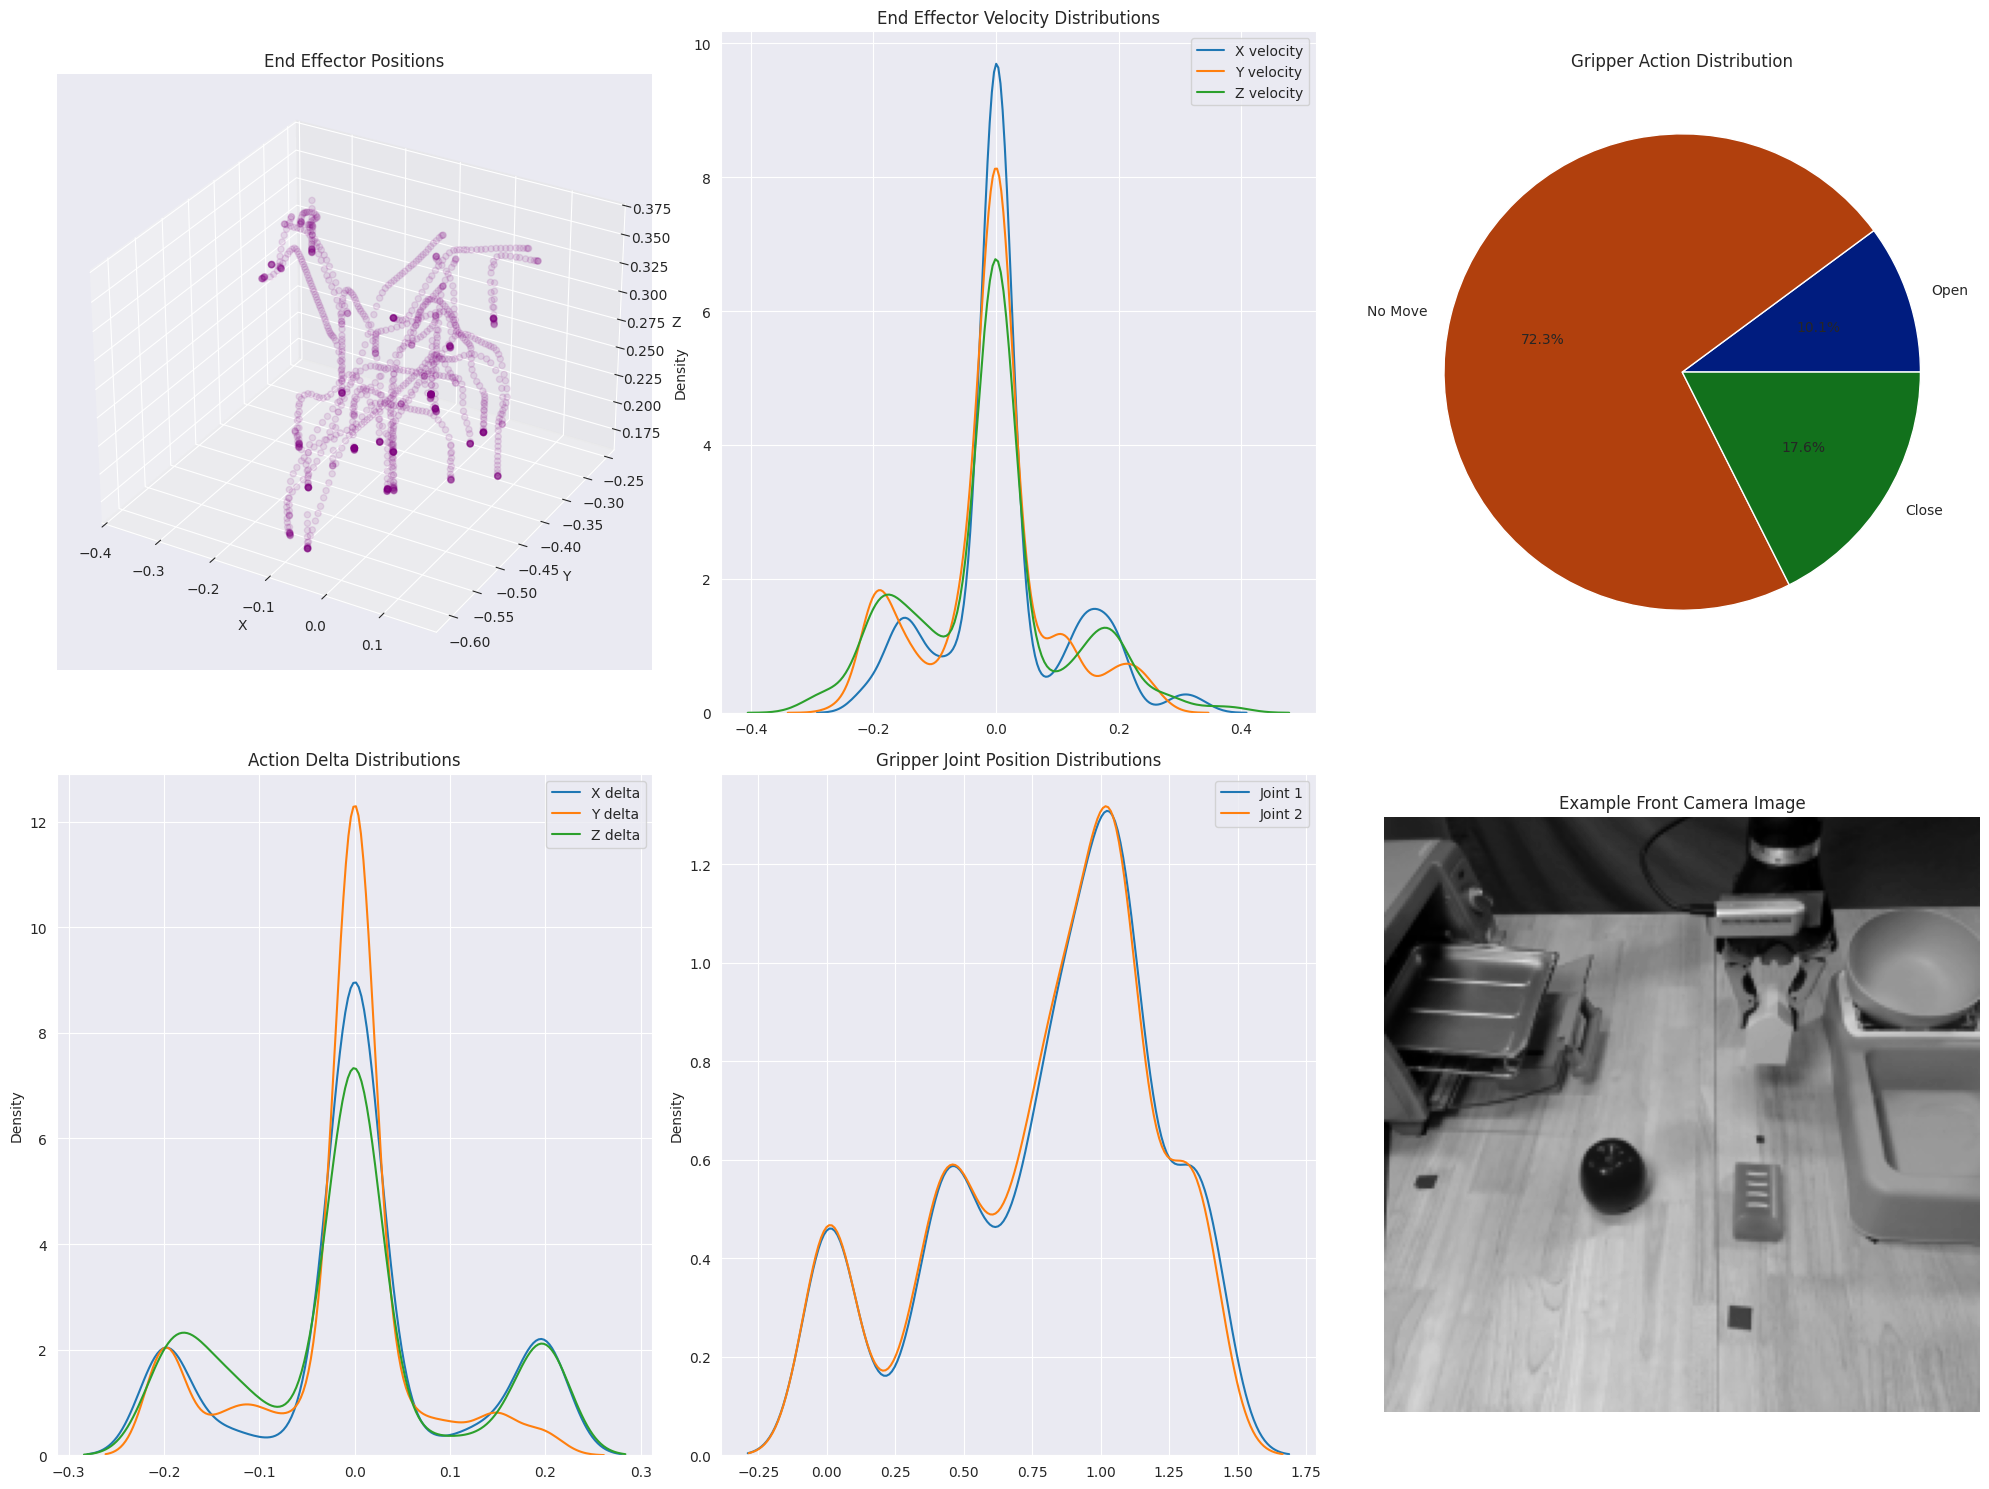

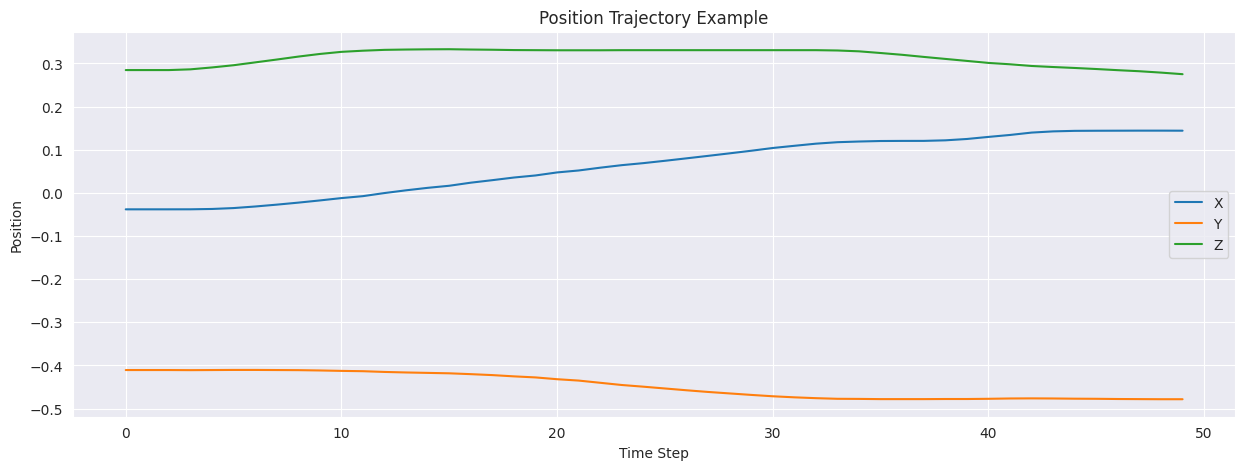

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
# Set up a large figure with multiple subplots
fig = plt.figure(figsize=(20, 15))

# 1. Cartesian Position Distribution (3D scatter plot)
ax1 = fig.add_subplot(231, projection='3d')
positions = train_nps['ee_cartesian_pos_ob'][:, 0:3]
ax1.scatter(positions[:, 0], positions[:, 1], positions[:, 2], alpha=0.1, color="purple")
ax1.set_title('End Effector Positions')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# 2. Velocity Distribution
ax2 = fig.add_subplot(232)
velocities = train_nps['ee_cartesian_vel_ob'][:, 0:3]
for i, dim in enumerate(['X', 'Y', 'Z']):
    sns.kdeplot(velocities[:, i], label=f'{dim} velocity', ax=ax2)
ax2.set_title('End Effector Velocity Distributions')
ax2.legend()

# 3. Gripper Action Distribution (Pie Chart)
ax3 = fig.add_subplot(233)
gripper_actions = train_nps['actions'][:, 3]
unique, counts = np.unique(gripper_actions, return_counts=True)
# sns.
colors = sns.color_palette('dark')

ax3.pie(counts, labels=['Open', 'No Move', 'Close'], autopct='%1.1f%%', colors=colors)
ax3.set_title('Gripper Action Distribution')

# 4. Action Deltas Distribution
ax4 = fig.add_subplot(234)
deltas = train_nps['actions'][:, 0:3]
for i, dim in enumerate(['X', 'Y', 'Z']):
    sns.kdeplot(deltas[:, i], label=f'{dim} delta', ax=ax4)
ax4.set_title('Action Delta Distributions')
ax4.legend()

# 5. Joint Positions Distribution
ax5 = fig.add_subplot(235)
joint_pos = train_nps['joint_pos_ob'][:, -2:]  # Last two elements
sns.kdeplot(joint_pos[:, 0], label='Joint 1', ax=ax5)
sns.kdeplot(joint_pos[:, 1], label='Joint 2', ax=ax5)
ax5.set_title('Gripper Joint Position Distributions')
ax5.legend()

# 6. Example Images
ax6 = fig.add_subplot(236)
example_front = ((train_nps['front_cam_ob'][0] - train_nps['front_cam_ob'][0].min()) * 
                (255/(train_nps['front_cam_ob'][0].max() - train_nps['front_cam_ob'][0].min()))).astype('uint8')
ax6.imshow(example_front, cmap='gray')
ax6.set_title('Example Front Camera Image')
ax6.axis('off')

plt.tight_layout()
plt.show()

# Additional temporal analysis
plt.figure(figsize=(15, 5))
# Plot trajectory example - position over time for a single sequence
sequence_length = 50  # Adjust based on your data
plt.plot(positions[:sequence_length, 0], label='X')
plt.plot(positions[:sequence_length, 1], label='Y')
plt.plot(positions[:sequence_length, 2], label='Z')
plt.title('Position Trajectory Example')
plt.xlabel('Time Step')
plt.ylabel('Position')
plt.legend()
plt.show()

float16
(224, 224)


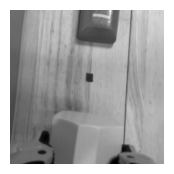

Shape: (224, 224)
Data type: float16
Value range: [21.15625, 226.875]


In [12]:
import matplotlib.pyplot as plt

for key in _keys:
    # if key == 'ee_cartesian_pos_ob':
    #     for action_idx in range(1000, 1010 ):
    #         print(train_nps[key][action_idx])    
    if key == 'actions':
        for action_idx in range(0, 1):
            print(train_nps[key][action_idx].dtype)
    if key == "mount_cam_ob":
        for image_idx in range(0, len(train_nps[key])):
            if image_idx < 1:
                img_array = train_nps[key][image_idx]
                print(img_array.shape)
                # img_array = ((img_array - img_array.min()) * (255/(img_array.max() - img_array.min()))).astype('uint8')
                plt.figure(figsize=(2,2))
                plt.imshow(img_array, cmap='gray') 
                plt.axis('off')
                plt.show()

                img_array = train_nps[key][image_idx]
                print(f"Shape: {img_array.shape}")
                print(f"Data type: {img_array.dtype}")
                print(f"Value range: [{img_array.min()}, {img_array.max()}]")                
                

In [13]:
# ******* INSERT YOUR CODE HERE *******
#TODO: Maybe dont change scaling of the Y coordinate.
def action_transform(x):
    # Standardize coordinates 
    movement = torch.tensor(
        (x[0:3] - train_nps['actions'][:,0:3].mean(axis=0)) / 
        train_nps['actions'][:,0:3].std(axis=0)
    )
    # Keep gripper as single integer value
    gripper = torch.tensor(int(x[3]), dtype=torch.long)  # Explicitly make it a long tensor for CrossEntropyLoss
    return torch.cat([movement, gripper.unsqueeze(0)])  # Keep 1D shape

"""Image means and stds"""
front_mean = (train_nps['front_cam_ob'].astype(np.float32) / 255.0).mean()
front_std = (train_nps['front_cam_ob'].astype(np.float32) / 255.0).std()
mount_mean = (train_nps['mount_cam_ob'].astype(np.float32) / 255.0).mean()
mount_std = (train_nps['mount_cam_ob'].astype(np.float32) / 255.0).std()

pos_tensor = torch.from_numpy(train_nps['ee_cartesian_pos_ob'])
vel_tensor = torch.from_numpy(train_nps['ee_cartesian_vel_ob'])
joint_tensor = torch.from_numpy(train_nps['joint_pos_ob'])


# TODO: Scale images by 255, calculate mean std AFTER scaled.  
"""TRANSFORMS"""
global_transforms = {
    # IMAGE transforms - normalize to [0,1] and standardize
    "front_cam_ob": transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x / 255.0)),
        transforms.Normalize(
            mean=[float(front_mean)],  # Convert to Python float
            std=[float(front_std)]     # Convert to Python float
        )
    ]),
    # IMAGE transforms - normalize to [0,1] and standardize
    "mount_cam_ob": transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x / 255.0)),        
        transforms.Normalize(
            mean=[float(mount_mean)],  # Convert to Python float
            std=[float(mount_std)]     # Convert to Python float
        )
    ]),
    # CONTINUOUS transforms
    "ee_cartesian_pos_ob": lambda x: (torch.tensor(x) - pos_tensor.mean(dim=0)) / pos_tensor.std(dim=0),
    # CONTINUOUS transforms
    "ee_cartesian_vel_ob": lambda x: (torch.tensor(x) - vel_tensor.mean(dim=0)) / vel_tensor.std(dim=0),
    # CONTINUOUS transforms values: Gripper joint positions standardization
    "joint_pos_ob": lambda x: (torch.tensor(x) - joint_tensor.mean(dim=0)) / joint_tensor.std(dim=0),
    # action gets special treatment.
    "actions": lambda x: action_transform(x)
}

#### Question 1.a.ii Justification (5 marks)
##### Task
- In the markdown cell below, justify your decisions for preprocessing including where you have decided __not__ to apply preprocessing. You should include empirical evidence from your EDA analysis to support your decisions. Justfication __without__ evidence will be rewarded 0 marks.

_actions_: **There are three potential actions our robot arm can take: Do Nothing: 0, Open Gripper: 1, Close Gripper: 2. An action is an array of 4 values, the first three being a coordinate to move to, and the last one the action [0-2]. Naturally, actions that have Do Nothing have a 0 coordinate. We don't need to One Hot Encode the [0-2] action as it is ordinal. But we should standardize the movement coordinates, as neural networks generally do better with standardized values. And we will also do the same for the other cartesian coordinates.**

_front_cam_ob_: **Our image data has already been preprocessed into 224x224 grayscale images thanks to Josh's package. So the only thing we need to do is normalize each pixel to 0-1. As well as converting it to a tensor.** 

_mount_cam_ob_: **Same as front_cam_ob, just normalize and convert to tensor.**
TODO: Should we normalize the quaternion?

_ee_cartesian_pos_ob_: **This data consists of 7 values. It uses (x,y,z) + (w,x,y,z) quaternion (7 values total). The quaternion is to avoid gimbal lock and is used in robotics a lot. Since these are continuos values we need to normalize and standardize them for the same reasons mentioned above.**

_ee_cartesian_vel_ob_: **This consists of 6 values, (x,y,z) and then (yaw, roll, pitch). Also continuous, so let's standardize it.**

_joint_pos_ob_: **This is a 2D vector representing the position of the joint for the gripper. It can only move in a 2D plane. Let's also standardize it.**

### Question 1.b End-to-end supervised model evaluation
The code below defines an end to end supervised model which: 
- Jointly encodes the two images ("front_cam_ob", "mount_cam_ob") using a CNN architecture (image_encoder);
- Seperately encoding the positional and velocity observations using an MLP;
- Combines the two embeddings by adding them together and;
- Passes the combined embedding into a final MLP layer (dense)
  
This question requires you to define sutable loss functions for the model and then evaluate the performance.

In [14]:
cnn2_config = ConvolutionLayersConfig(
    input_dim=224,
    input_channels=2,
    layers=[
        nn.Conv2d(
            in_channels=2,
            out_channels=8,
            kernel_size=(3,3),
            stride=1,
            padding=1,
            dilation=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
        ]
    )

_cnn_output_dim = cnn2_config.get_output_dims()
_cnn_output_channels = cnn2_config.get_output_channels()
_mlp_input_dim = int(
            (_cnn_output_dim[-1]*_cnn_output_dim[-1])*_cnn_output_channels[-1]
            )


image_encoder = JointCNNEncoder(
    cnn=CNN(cnn2_config),
    dense=MLP(
        input_dim=_mlp_input_dim,
        hidden_dims=[256],
        output_dim=128
        )
)

obs_encoder = MLP(
    input_dim = 15,
    hidden_dims = [256,256],
    output_dim = 128
)

dense = MLP(
    input_dim = 128,
    hidden_dims = [64,32],
    output_dim = 6
)

class Baseline1(BaseModel):
  def __init__(
      self,
      image_encoder:JointCNNEncoder,
      obs_encoder:MLP,
      dense:MLP
      ) -> None:
      super().__init__()
      self.image_encoder = image_encoder
      self.obs_encoder = obs_encoder
      self.dense = dense

  def forward(self, images, obs):
    _img_enc = self.image_encoder(images)
    _obs_enc = self.obs_encoder(obs)
    _dense_enc = self.dense(_img_enc+_obs_enc)
    pos = _dense_enc[:,0:3]
    grp = _dense_enc[:,3:]
    return {
        "pos": pos,
        "grp":grp
        }
  def reset(
      self,
      image_encoder_kwargs,
      obs_encoder_kwargs,
      dense_kwargs
      ):
    self.image_encoder.reset(**image_encoder_kwargs)
    self.obs_encoder.reset(**obs_encoder_kwargs)
    self.dense.reset(**dense_kwargs)

torch.manual_seed(1)
model = Baseline1(
    image_encoder=image_encoder,
    obs_encoder=obs_encoder,
    dense=dense
)

#### Question 1.b.i Loss definitions (3 marks)
For the model defined above, the proposed loss function is defined where the contribution of "pos_criterion" and "grp_criterion" are equally weighted and the mean of the two values loss are used to define the final loss. Furthermore, the loss for the positional actions is the MSE and the loss for grp_criterion is the CrossEntropyLoss.

##### Task:
- Justify why this composite loss function is reasonable. You should make reference to the range of values predicted by the deep learning model.

**Justification: MSE Loss and Cross Entropy Loss**

In [15]:
pos_criterion = nn.MSELoss(reduction="mean")
grp_criterion = nn.CrossEntropyLoss(reduction="mean")

In [16]:
torch.manual_seed(1)
model.reset({},{},{})
exp_kwargs = {
    "batch_size": 64,
    "learning_rate": 0.001,
    "half_precision": True,
    "target_offset": 0
}

if project_options.debug:
    exp_kwargs["batch_size"] = 4

if exp_kwargs["half_precision"]:
    train_dataset = NpDictDataset(
        array_dict=train_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict=val_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )
else:
    train_dataset = NpDictDataset(
        array_dict={k:train_nps[k].astype(np.float32) for k in train_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict={k:val_nps[k].astype(np.float32) for k in val_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

print(len(train_dataset))
out = train_dataset[0]

def collate_func(input_list:List[DatasetOutput])->DatasetOutput:
    pos = []
    _grp = []
    images = []
    obs = []
    for val in input_list:
        images.append(
            torch.concat(
                [val.input["front_cam_ob"], val.input["mount_cam_ob"]],
                dim=0
            )[None,:]
            )
        obs.append(
            torch.concat(
                [
                    val.input["ee_cartesian_pos_ob"],
                    val.input["ee_cartesian_vel_ob"],
                    val.input["joint_pos_ob"]
                    ],
                dim=0
            )[None,:]
        )
        pos.append(val.output["actions"][0:3][None,:])
        _grp.append(val.output["actions"][-1:][None])
    _grp = torch.concat(_grp, dim=0)
    grp = torch.zeros(_grp.shape[0],3)
    grp[torch.arange(len(grp)), _grp.squeeze().int()] = 1
    return DatasetOutput(
        input = {
            "images":torch.concat(images,dim=0),
            "obs":torch.concat(obs,dim=0),
            },
        output = {
            "pos":torch.concat(pos, dim=0),
            "grp":grp
            }
    )


train_dataloader = DataLoader(
    train_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=True,
    collate_fn=collate_func,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func,
)

first_batch = next(train_dataloader.__iter__())

input_dim = first_batch.input["images"].shape
print(input_dim)
input_dim = first_batch.input["obs"].shape
print(input_dim)
pos_dim = first_batch.output["pos"].shape
print(pos_dim)
grp_dim = first_batch.output["grp"].shape
print(grp_dim)

exp_kwargs["model_def"] = model.__repr__()


if exp_kwargs["half_precision"]:
    model = model.half()
optimizer = torch.optim.Adam(
    model.parameters(), lr=exp_kwargs["learning_rate"],
    eps=1e-04
    )

__criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":pos_criterion,
        "grp": grp_criterion
    }
    )

if exp_kwargs["half_precision"]:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            with torch.autocast(device_type="cuda"):
                res = model(
                    images=first_batch.input["images"].cuda(),
                    obs=first_batch.input["obs"].cuda()
                    )
                first_batch.output["pos"] = first_batch.output["pos"].cuda()
                first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            with torch.autocast(device_type="cpu"):
                res = model(
                    images=first_batch.input["images"],
                    obs=first_batch.input["obs"]
                    )
else:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            res = model(
                images=first_batch.input["images"].cuda(),
                obs=first_batch.input["obs"].cuda()
                )
            first_batch.output["pos"] = first_batch.output["pos"].cuda()
            first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            res = model(
                images=first_batch.input["images"],
                obs=first_batch.input["obs"]
                )
print(__criterion(res,first_batch.output))


1274
torch.Size([4, 2, 224, 224])
torch.Size([4, 15])
torch.Size([4, 3])
torch.Size([4, 3])
tensor(1.5918, device='cuda:0', dtype=torch.float16)


In [17]:

# mo = WandBMetricOrchestrator()
# import logging
# logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)
# logging.debug("test")

# train_criterion = TrackerBalancedLoss(
#     loss_lkp={
#         "pos":copy.deepcopy(pos_criterion),
#         "grp":copy.deepcopy(grp_criterion)
#     },
#     name="train",
#     mo=mo
#     )

# val_criterion = TrackerBalancedLoss(
#     loss_lkp={
#         "pos":copy.deepcopy(pos_criterion),
#         "grp":copy.deepcopy(grp_criterion)
#     },
#     name="val",
#     mo=mo
#     )

# sl_trainer = TorchTrainingLoop(
#     model=model, gpu=True, optimizer=optimizer, criterion=train_criterion,
#     val_criterion=val_criterion, epochs=10, logger=logger,
#     mo=WandBMetricOrchestrator(), half_precision=exp_kwargs["half_precision"],
#     preds_save_type=None
# )

# wandb_name = "End_to_end_1"
# wandb_grp="End_to_end"

# if project_options.debug:
#     wandb_name = f"{wandb_name}_DEBUG"

# orig = datetime.datetime.now()
# sl_trainer.training_loop(
#     train_loader=train_dataloader,
#     val_loader=val_dataloader,
#     wandb_proj=WANDB_PROJECT,
#     wandb_grp=wandb_grp,
#     # logger=logger,
#     wandb_config=exp_kwargs,
#     wandb_name=wandb_name,
#     reset_kwargs={
#         "image_encoder_kwargs": {},
#         "obs_encoder_kwargs": {},
#         "dense_kwargs": {}
#     }
#     )
# post_train = datetime.datetime.now()


# # Configure logger



#### Question 1.b.ii Model evaluation (marks broken down in sub questions)
This question requires you to evaluate the perfomance of the model defined above by interpreting model training/validation metrics and investigating the specific failure modes of the model. Run the cells above which will train the model for 10 epochs. 

**IMPORTANT, for questions (1.b.ii.i, 1.b.ii.ii, 1.b.ii.ii)** 
- You are **not** expected to train a baseline model and you will be awarded **0 marks** for training such a model and evaluating performance against it. 
- Furthermore, when interpretting the metric(s) and justifying your conclusions, you will loose marks for failing to comment on striking results that are obvious to the marker.
- **Incorrect interpretations of metrics** will be **negatively penalised**
- Finally, where you have been asked for empirical evidence, but provide none, you will be awarded __0 marks__.

#### Question 1.b.ii.i Epoch selection (3 marks)
##### Task
- Select an appropriate epoch using a suitable method, provide __empirical evidence__ for your choice.

#### Question 1.b.ii.ii Performance evaluation (8 marks)
##### Task
- Draw conclusions regarding how well the model performs. To do this you may want to use additional metrics to the one(s) already reported. Critically, you should __contextualise__ the performance of the model. We are expecting discussion points a long the lines: _The model achieved a score of X according to metric Y. This suggests that the model is/is not performing well, because..._

#### Question 1.b.ii.iii Model failure modes (9 marks)
##### Task
- Investigate the failure modes of the model. You should: 
  - Demonstrate the failure mode using **empirical evidence** e.g., _the model fails on X observations as demonstrated by..._
  - Assess the impact of these failure modes using **empirical evidence** i.e., how significant is this problem. You should consider both metrics and dataset coverage
  - Conclude __why__ the model might be failing on these observations **empirical evidence** e.g., _X part of the model performs poorly, as demonstrated by..._

__IMPORTANT__:
- Marks will be penalised if the failure modes you identify are not systematic i.e., you select a single observation that the model fails on. If you cannot identify any general failure modes of the model, you will be awarded full marks if you provide empirical evidence justifying why there are no systematic failure modes which sufficienty accounts for the diversity of observations in the dataset.


### Question 1.c Model tuning
Now you have evaluated the proposed model, you are required to iterate and train a higher performing one. You are expected to run experiments that help you understand where the model is underperforming, guiding your development.

#### Question 1.c.i Model tuning (5 marks)
##### Task
- Using the code blocks below, implement a model which improves over the previous. Improve the performance as best you can and report the results using the metric/metrics you used in question 1.b.ii Model evaluation. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

In [18]:
# ******* INSERT YOUR CODE HERE *******

# ******* INSERT YOUR CODE HERE - END *******

#### Question 1.c.ii Discussion (marks broken down in subsections below)

##### Task
In the markdown blocks below, discuss **three** experiments that you ran during the development of your model, defined in 1.c.i Model tuning which were the **most insightful** with respect to the design of your final model. Importantly, **most insightful** needn't necessarily be the final decisions that appear in the model defined in question 1.c.i Model tuning, rather they should be experiments that most shaped your model development process. For example: 
- You might decide to use a learning rate scheduler and decrease the learning rate at epoch 10 (call this experiment "EXP_LR");
- This experiment produces a jump in performance and unlocks a series of further fruitful experiments into learning rate scheduling;
- However, in the model reported in question 1.c.i Model tuning, you use a learning rate schedule with descreases at epochs 6 and 15 (since these produced a marginal performance over "EXP_LR")
- For this question __you should discuss EXP_LR__.
  
For each experiment, complete the "Description", "Result" and "Conclusion" sections where the following information should be provided:
* __Description__: What delta were you measuring i.e., change of architecture, change of learning rate etc?
* __Justification__: **Why** are you conducting the experiment?
  * What was the context of the model development process up to this point? What did you already know about how well the model performed/why it was performing/what were the challenging data points?
* __Conclusion__: What did you __learn__ from the experiment and provide __empirical evidence__ to support this claim. In drawing your conclusions, consider where there are multiple possible causes for the model failing, ensure you provide evidence for each of these and conclude whether or not they might be root cause (you may conclude that there are multiple causes).

**IMPORTANT** If your reported experiments are **not** well motivated and do not demonstrate that you have integrogated the model performance, you will be deducted marks. An example of poor motovation might be: *I chose to decrease the learning rate from X to Y as I did not know what impact this might have*. This justification could be improved by explaining what you __already know__ about how the learning rate might be affecting the model. What hypotheses might you draw about what the experiment will show?



#### Question 1.c.ii.i Experiment 1 discussion (10 marks)

##### Description


##### Justification


##### Conclusion

#### Question 1.c.ii.ii Experiment 2 discussion (10 marks)

##### Description


##### Justification


##### Conclusion

#### Question 1.c.ii.iii Experiment 3 discussion (10 marks)

##### Description


##### Justification


##### Conclusion

## Question 2 Self-supervised pretraining with VAEs

This question requires you to implement a self-supervised approach using a VAE architecture. The focus of question 2 is in developing a VAE model without using __any__ supervised information i.e., without using any action information. You will assess the convergence of the model and the suitability of the learnt latent space. You are required to select and appropriate architecture/loss function/target set of observations to perform self-supervised learning over.

__IMPORTANT__: Do not use any of the __action__ information. You will be awarded 0 marks if you do.

### Question 2.a Self-supervised VAE model (5 marks)

##### Task
- Implement the full model training process and model definiton in the code block below. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

In [19]:
"""VAE Dataloaders"""

def create_vae_dataloaders(train_nps: dict, val_nps: dict, batch_size: int, global_transforms: dict, collate_fn_vae: callable):
    """
    Create training and validation dataloaders for the VAE
    
    Args:
        train_nps (dict): Training data dictionary
        val_nps (dict): Validation data dictionary
        batch_size (int): Batch size
        global_transforms (dict): Dictionary of transforms
        collate_fn_vai: Collate method
        
    Returns:
        tuple: (train_dataloader, val_dataloader)
    """
    # Create training dataset
    train_dataset = NpDictDataset(
        array_dict=train_nps,
        transform_lkp=global_transforms,
        dep_vars=[],  # No dependent variables for self-supervised learning
        indep_vars=[
            "front_cam_ob",
            "mount_cam_ob",
            "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob",
            "joint_pos_ob"
        ]
    )
    
    # Create validation dataset
    val_dataset = NpDictDataset(
        array_dict=val_nps,
        transform_lkp=global_transforms,
        dep_vars=[],  # No dependent variables for self-supervised learning
        indep_vars=[
            "front_cam_ob",
            "mount_cam_ob",
            "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob",
            "joint_pos_ob"
        ]
    )
    
    # Create dataloaders
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn_vae,
        num_workers=4,
        pin_memory=True
    )
    
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn_vae,
        num_workers=4,
        pin_memory=True
    )
    
    return train_dataloader, val_dataloader


def collate_fn_vae(batch_list):
    """
    Custom collate function for VAE dataloader that properly combines all inputs
    """
    # Initialize lists for each modality
    images = []
    obs = []
    
    for sample in batch_list:
        # Combine front and mount camera images
        combined_img = torch.cat([
            sample.input["front_cam_ob"], 
            sample.input["mount_cam_ob"]
        ], dim=0).half()  # Convert to half precision
        
        # Combine numerical observations
        combined_obs = torch.cat([
            sample.input["ee_cartesian_pos_ob"],
            sample.input["ee_cartesian_vel_ob"], 
            sample.input["joint_pos_ob"]
        ], dim=0).half()  # Convert to half precision
        
        images.append(combined_img)
        obs.append(combined_obs)
    
    # Stack into batches
    images = torch.stack(images)  # Shape: [batch_size, 2, 224, 224]
    obs = torch.stack(obs)      # Shape: [batch_size, 15]
    
    return DatasetOutput(
        input={
            "images": images,
            "obs": obs
        },
        output={}
    )



Notes:

https://www.youtube.com/watch?v=VELQT1-hILo

https://www.youtube.com/watch?v=qJeaCHQ1k2w&t=524s


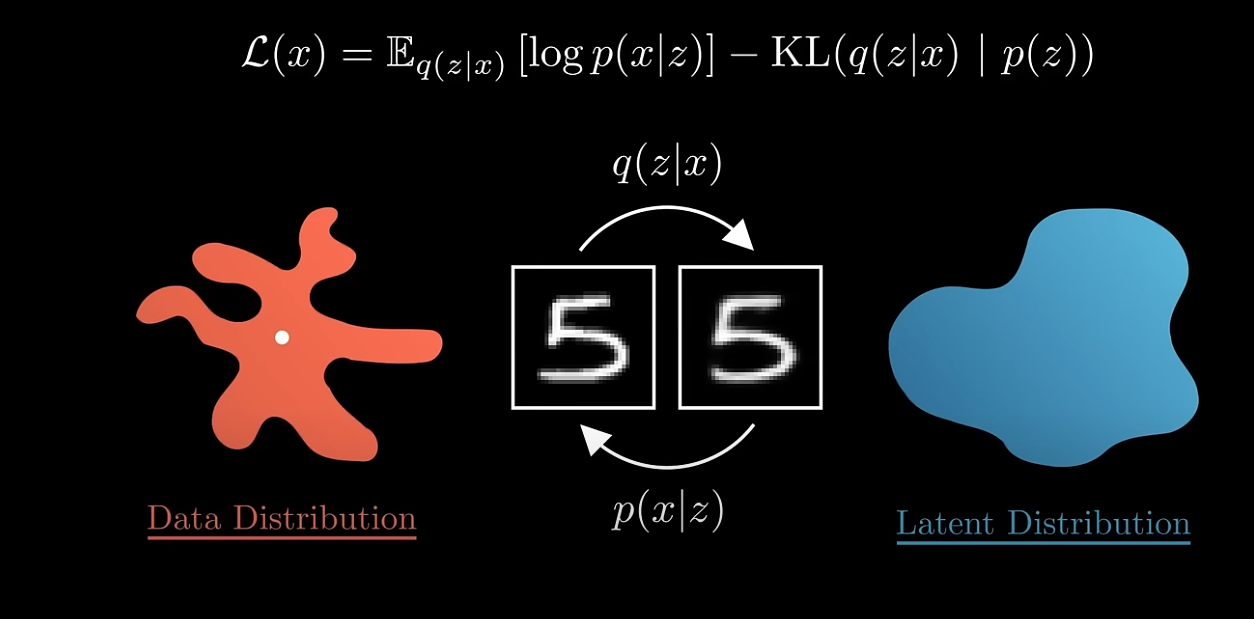


In [20]:
import torch.nn.functional as F
import wandb

from utils.vae_utils import VAELossPlotter

#NOTE: inspiration from https://www.youtube.com/watch?v=VELQT1-hILo

class VAE(nn.Module):
    def __init__(self, image_size=224, latent_dim=128):
        super().__init__()
        self.image_size = image_size
        self.latent_dim = latent_dim
        
        
        # /
        # |
        # |
        # \
        # Encoder for front and mount camera images
        self.image_encoder = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        # Encoder for numerical observations
        self.numerical_encoder = nn.Sequential(
            nn.Linear(15, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        # Calculate flattened size of image features
        self._img_feat_size = 256 * (image_size // 16) * (image_size // 16)
        
        # Latent space projections
        self.fc_mu = nn.Linear(self._img_feat_size + 64, latent_dim)
        self.fc_logvar = nn.Linear(self._img_feat_size + 64, latent_dim)
        
        # Decoder layers
        self.decoder_linear = nn.Linear(latent_dim, self._img_feat_size + 64)
        
        # Image decoder
        self.image_decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        
        # Numerical decoder
        self.numerical_decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 15)
        )
        
        # Convert model to half precision
        self.half()

    def encode(self, x_img, x_num):
        # Ensure inputs are half precision
        x_img = x_img.half()
        x_num = x_num.half()
        
        # Encode images
        img_features = self.image_encoder(x_img)
        img_features = img_features.view(img_features.size(0), -1)
        
        # Encode numerical data
        num_features = self.numerical_encoder(x_num)
        
        # Combine features
        combined = torch.cat([img_features, num_features], dim=1)
        
        # Project to latent space
        mu = self.fc_mu(combined)
        logvar = self.fc_logvar(combined)
        
        return mu, logvar
    
    def decode(self, z):
        # Ensure latent vector is half precision
        z = z.half()
        
        # Decode to combined feature space
        combined = self.decoder_linear(z)
        
        # Split features
        img_features = combined[:, :self._img_feat_size]
        num_features = combined[:, self._img_feat_size:]
        
        # Reshape image features
        img_size = self.image_size // 16
        img_features = img_features.view(-1, 256, img_size, img_size)
        
        # Decode images and numerical data
        decoded_img = self.image_decoder(img_features)
        decoded_num = self.numerical_decoder(num_features)
        
        return decoded_img, decoded_num    
    
    def reparameterize(self, mu, logvar):
        if self.training:
            # Clamp logvar to prevent numerical instability
            logvar = torch.clamp(logvar, -20, 2)
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu


    def forward(self, x_img, x_num):
        # Ensure inputs are half precision
        x_img = x_img.half()
        x_num = x_num.half()
        
        mu, logvar = self.encode(x_img, x_num)
        z = self.reparameterize(mu, logvar)
        decoded_img, decoded_num = self.decode(z)
        return decoded_img, decoded_num, mu, logvar

def vae_loss(recon_img, x_img, recon_num, x_num, mu, logvar, beta=1.0):
    """
    Numerically stable VAE loss that returns all components
    """
    # Clamp values for numerical stability
    eps = 1e-6
    
    # MSE losses with gradient clipping
    recon_loss_img = F.mse_loss(
        torch.clamp(recon_img, -10, 10),
        torch.clamp(x_img, -10, 10),
        reduction='mean'
    )
    
    recon_loss_num = F.mse_loss(
        torch.clamp(recon_num, -10, 10),
        torch.clamp(x_num, -10, 10),
        reduction='mean'
    )

    # Numerically stable KL divergence
    kld = -0.5 * torch.mean(
        1 + torch.clamp(logvar, -20, 2) - mu.pow(2) - torch.exp(torch.clamp(logvar, -20, 2))
    )

    # Scale losses
    total_loss = recon_loss_img + 0.1 * recon_loss_num + beta * kld
    
    return total_loss, recon_loss_img, recon_loss_num, kld



# Modify the train_vae function to work with the new dataloader format
def train_vae(model, train_loader: DataLoader, val_loader: DataLoader, optimizer, device, num_epochs=10, beta=1.0):
    """
    Training loop for VAE with validation and half precision handling
    """
    model = model.to(device)
    loss_plotter = VAELossPlotter()
    
    for epoch in range(num_epochs):
        model.train()
        train_total = 0
        train_recon_img = 0
        train_recon_num = 0
        train_kld = 0
        
        for batch_idx, batch in enumerate(train_loader):
            x_img = batch.input["images"].to(device)
            x_num = batch.input["obs"].to(device)
            
            with torch.autocast('cuda'):
                optimizer.zero_grad()
                recon_img, recon_num, mu, logvar = model(x_img, x_num)
                total_loss, recon_loss_img, recon_loss_num, kld = vae_loss(
                    recon_img, x_img, recon_num, x_num, mu, logvar, beta
                )
            
            total_loss.backward()
            optimizer.step()
            
            # Accumulate losses
            train_total += total_loss.item()
            train_recon_img += recon_loss_img.item()
            train_recon_num += recon_loss_num.item()
            train_kld += kld.item()
        
        # Validation
        model.eval()
        val_total = 0
        val_recon_img = 0
        val_recon_num = 0
        val_kld = 0
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                x_img = batch.input["images"].to(device)
                x_num = batch.input["obs"].to(device)
                
                with torch.autocast('cuda'):
                    recon_img, recon_num, mu, logvar = model(x_img, x_num)
                    total_loss, recon_loss_img, recon_loss_num, kld = vae_loss(
                        recon_img, x_img, recon_num, x_num, mu, logvar, beta
                    )
                
                val_total += total_loss.item()
                val_recon_img += recon_loss_img.item()
                val_recon_num += recon_loss_num.item()
                val_kld += kld.item()
        
        # Calculate averages
        train_total /= len(train_loader.dataset)
        train_recon_img /= len(train_loader.dataset)
        train_recon_num /= len(train_loader.dataset)
        train_kld /= len(train_loader.dataset)
        
        val_total /= len(val_loader.dataset)
        val_recon_img /= len(val_loader.dataset)
        val_recon_num /= len(val_loader.dataset)
        val_kld /= len(val_loader.dataset)
        
        # Add to plotter
        loss_plotter.add_epoch_losses(
            epoch=epoch,
            train_total_loss=train_total,
            train_recon_img_loss=train_recon_img,
            train_recon_num_loss=train_recon_num,
            train_kl_loss=train_kld,
            val_total_loss=val_total,
            val_recon_img_loss=val_recon_img,
            val_recon_num_loss=val_recon_num,
            val_kl_loss=val_kld
        )
        
        print(f'Epoch {epoch}:')
        print(f'Train - Total: {train_total:.4f}, Img: {train_recon_img:.4f}, '
              f'Num: {train_recon_num:.4f}, KLD: {train_kld:.4f}')
        print(f'Val   - Total: {val_total:.4f}, Img: {val_recon_img:.4f}, '
              f'Num: {val_recon_num:.4f}, KLD: {val_kld:.4f}')
    
    # Plot final results
    loss_plotter.plot_losses()
    loss_plotter.plot_loss_ratios()
    loss_plotter.plot_loss_distributions()
    
    return loss_plotter  # Return for further analysis if needed

In [21]:
def analyze_dataloader(dataloader, num_batches=5):
    """
    Analyze the first few batches of data to check for NaNs, zeros, and value ranges
    """
    print("\nDataLoader Analysis:")
    print("-------------------")

    for batch_idx, batch in enumerate(dataloader):
        if batch_idx >= num_batches:
            break
            
        print(f"\nBatch {batch_idx + 1}:")
        
        # Analyze images
        images = batch.input["images"]
        print("\nImages:")
        print(f"Shape: {images.shape}")
        print(f"Type: {images.dtype}")
        print(f"Range: [{images.min().item():.3f}, {images.max().item():.3f}]")
        print(f"Mean: {images.mean().item():.3f}")
        print(f"NaN count: {torch.isnan(images).sum().item()}")
        print(f"Zero count: {(images == 0).sum().item()}")
        
        # Analyze numerical observations
        obs_types = ["ee_cartesian_pos_ob", "ee_cartesian_vel_ob", "joint_pos_ob"]
        
        for obs_type in obs_types:
            if obs_type in batch.input:
                obs = batch.input[obs_type]
                print(f"\n{obs_type}:")
                print(f"Shape: {obs.shape}")
                print(f"Type: {obs.dtype}")
                print(f"Range: [{obs.min().item():.3f}, {obs.max().item():.3f}]")
                print(f"Mean: {obs.mean().item():.3f}")
                print(f"NaN count: {torch.isnan(obs).sum().item()}")
                print(f"Zero count: {(obs == 0).sum().item()}")
                
                # Show histogram of values
                if batch_idx == 0:
                    plt.figure(figsize=(10, 4))
                    plt.hist(obs.numpy().flatten(), bins=50)
                    plt.title(f'Distribution of {obs_type} values')
                    plt.xlabel('Value')
                    plt.ylabel('Count')
                    plt.show()

    print("\nDataLoader Analysis Complete")
    print("-------------------------")

# Create and analyze dataloaders
testing_train_dataloader, testing_val_dataloader = create_vae_dataloaders(train_nps, val_nps, 32, global_transforms, collate_fn_vae)

print("Analyzing Training DataLoader:")
analyze_dataloader(testing_train_dataloader)

print("\nAnalyzing Validation DataLoader:")
analyze_dataloader(testing_val_dataloader)

Analyzing Training DataLoader:

DataLoader Analysis:
-------------------

Batch 1:

Images:
Shape: torch.Size([32, 2, 224, 224])
Type: torch.float16
Range: [-2.648, 2.662]
Mean: 0.000
NaN count: 0
Zero count: 1760

Batch 2:

Images:
Shape: torch.Size([32, 2, 224, 224])
Type: torch.float16
Range: [-2.650, 2.660]
Mean: -0.030
NaN count: 0
Zero count: 2014

Batch 3:

Images:
Shape: torch.Size([32, 2, 224, 224])
Type: torch.float16
Range: [-2.639, 2.662]
Mean: -0.021
NaN count: 0
Zero count: 2138

Batch 4:

Images:
Shape: torch.Size([32, 2, 224, 224])
Type: torch.float16
Range: [-2.652, 2.656]
Mean: -0.010
NaN count: 0
Zero count: 2033

Batch 5:

Images:
Shape: torch.Size([32, 2, 224, 224])
Type: torch.float16
Range: [-2.648, 2.660]
Mean: 0.005
NaN count: 0
Zero count: 2242

DataLoader Analysis Complete
-------------------------

Analyzing Validation DataLoader:

DataLoader Analysis:
-------------------

Batch 1:

Images:
Shape: torch.Size([32, 2, 224, 224])
Type: torch.float16
Range: [-2.

In [22]:
# Print the transforms we're using
print("Global Transforms:")
for k, v in global_transforms.items():
    print(f"{k}: {v}")

# Let's check a single sample before and after transformation
print("\nChecking single sample transformation:")
idx = 0  # Check first sample

print("\nBefore transformation:")
for key in ["front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob", "ee_cartesian_vel_ob", "joint_pos_ob"]:
    data = train_nps[key][idx]
    print(f"\n{key}:")
    print(f"Shape: {data.shape}")
    print(f"Type: {data.dtype}")
    print(f"Range: [{data.min()}, {data.max()}]")
    print(f"Mean: {data.mean()}")

# Apply transforms to single sample
print("\nAfter transformation:")
transformed_data = {}
for key in ["front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob", "ee_cartesian_vel_ob", "joint_pos_ob"]:
    transformed_data[key] = global_transforms[key](train_nps[key][idx])
    print(f"\n{key}:")
    print(f"Shape: {transformed_data[key].shape}")
    print(f"Type: {transformed_data[key].dtype}")
    print(f"Range: [{transformed_data[key].min().item()}, {transformed_data[key].max().item()}]")
    print(f"Mean: {transformed_data[key].mean().item()}")

Global Transforms:
front_cam_ob: Compose(
    ToTensor()
    Lambda()
    Normalize(mean=[0.4484155476093292], std=[0.216434046626091])
)
mount_cam_ob: Compose(
    ToTensor()
    Lambda()
    Normalize(mean=[0.5031079649925232], std=[0.18617898225784302])
)
ee_cartesian_pos_ob: <function <lambda> at 0x7f6844110b80>
ee_cartesian_vel_ob: <function <lambda> at 0x7f6844110c10>
joint_pos_ob: <function <lambda> at 0x7f6844110a60>
actions: <function <lambda> at 0x7f6844110dc0>

Checking single sample transformation:

Before transformation:

front_cam_ob:
Shape: (224, 224)
Type: float16
Range: [0.896484375, 233.0]
Mean: 115.8125

mount_cam_ob:
Shape: (224, 224)
Type: float16
Range: [21.15625, 226.875]
Mean: 137.375

ee_cartesian_pos_ob:
Shape: (7,)
Type: float16
Range: [-0.41064453125, 0.9892578125]
Mean: 0.138427734375

ee_cartesian_vel_ob:
Shape: (6,)
Type: float16
Range: [-0.00922393798828125, 0.043426513671875]
Mean: 0.0081939697265625

joint_pos_ob:
Shape: (2,)
Type: float16
Range: [1.04

In [23]:
from dataclasses import dataclass


"""Using a dataclass to store my hyperparams.
This is so much better than using a dictionary.
"""
@dataclass(frozen=True)
class VAEHyperParams:
    NUM_EPOCHS: int = 10
    BETA: float = 0.1
    BATCH_SIZE: int = 64
    IMAGE_SIZE: int = 224
    LATENT_DIM: int = 128
    LEARNING_RATE: float = 1e4
    EPSILON: float = 1e4

    
params = VAEHyperParams()


Epoch 0:
Train - Total: 0.1810, Img: 0.0168, Num: 1.2925, KLD: 0.3502
Val   - Total: 0.3143, Img: 0.0175, Num: 1.7274, KLD: 1.2406
Epoch 1:
Train - Total: 0.1825, Img: 0.0157, Num: 1.5751, KLD: 0.0929
Val   - Total: 0.1923, Img: 0.0176, Num: 1.7140, KLD: 0.0329
Epoch 2:
Train - Total: 0.2021, Img: 0.0157, Num: 1.5845, KLD: 0.2799
Val   - Total: 0.1956, Img: 0.0175, Num: 1.6722, KLD: 0.1081
Epoch 3:
Train - Total: 0.2659, Img: 0.0157, Num: 1.5745, KLD: 0.9276
Val   - Total: 0.4914, Img: 0.0175, Num: 1.7460, KLD: 2.9923
Epoch 4:
Train - Total: 0.2272, Img: 0.0157, Num: 1.5854, KLD: 0.5296
Val   - Total: 0.2000, Img: 0.0176, Num: 1.7141, KLD: 0.1096
Epoch 5:
Train - Total: 0.2037, Img: 0.0157, Num: 1.5851, KLD: 0.2950
Val   - Total: 0.1883, Img: 0.0176, Num: 1.7052, KLD: 0.0019
Epoch 6:
Train - Total: 0.1764, Img: 0.0157, Num: 1.5863, KLD: 0.0210
Val   - Total: 0.1905, Img: 0.0176, Num: 1.7228, KLD: 0.0066
Epoch 7:
Train - Total: 0.1843, Img: 0.0157, Num: 1.5861, KLD: 0.1001
Val   - Total

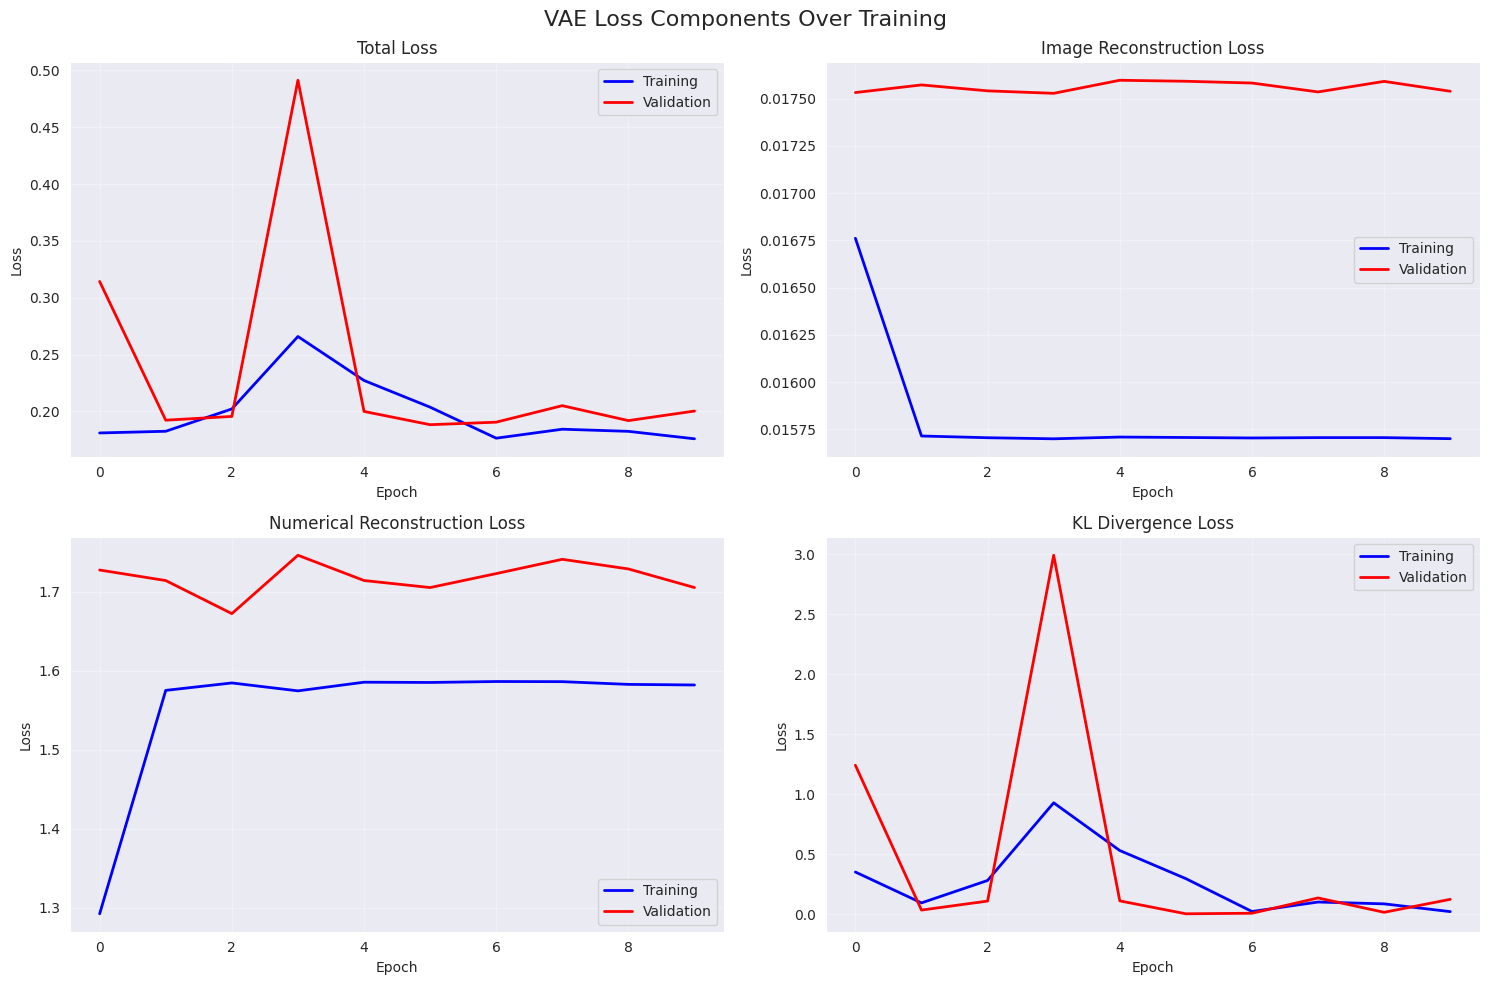

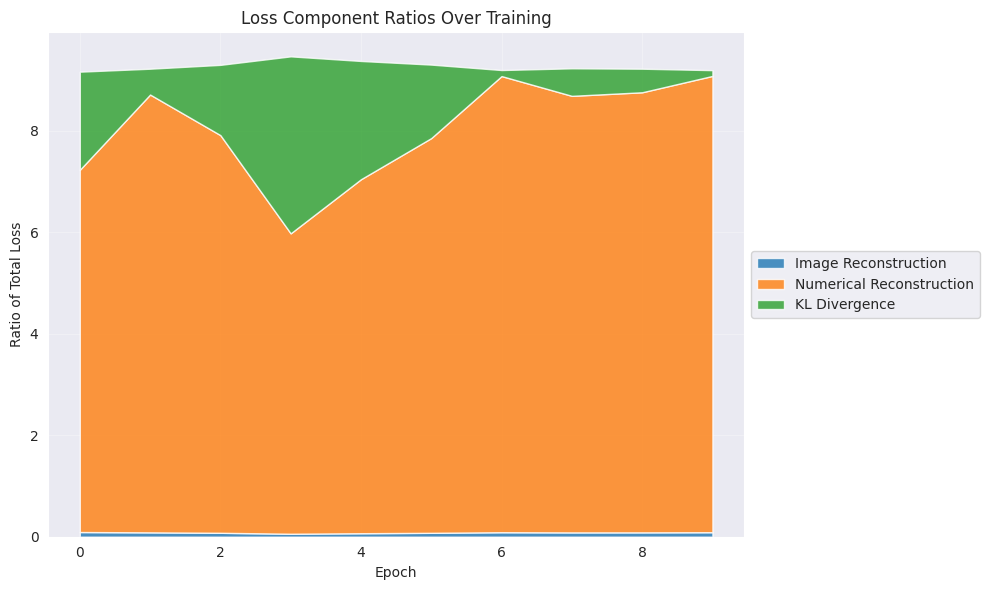

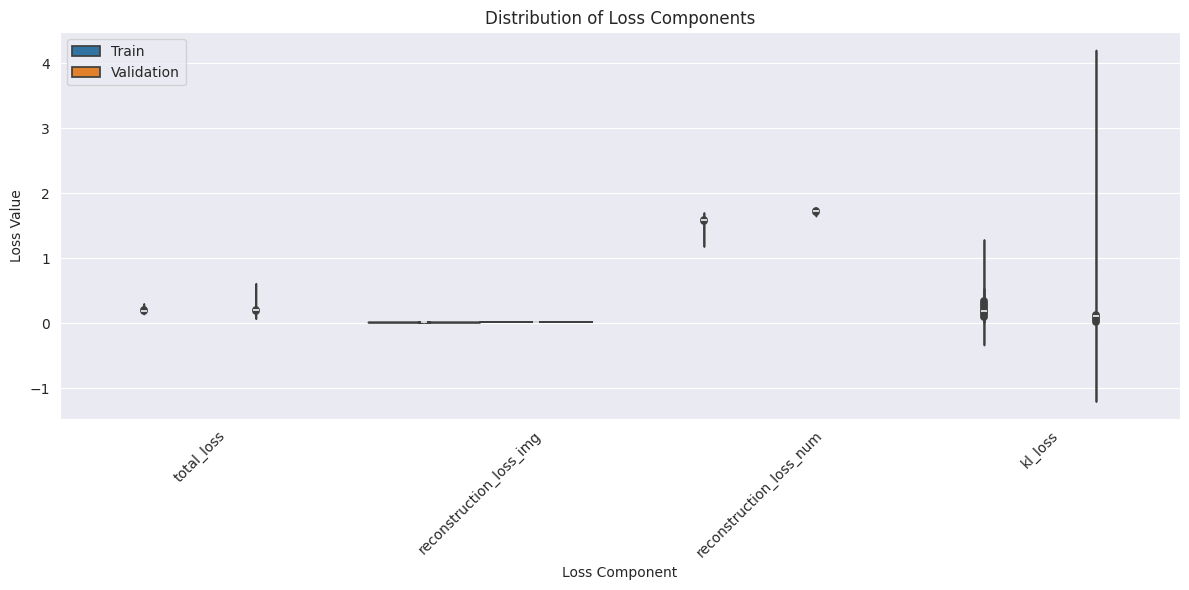

In [24]:
# Set random seed for reproducibility

torch.manual_seed(1)

train_dataloader, val_dataloader = create_vae_dataloaders(train_nps, val_nps, params.BATCH_SIZE, global_transforms, collate_fn_vae)

# Initialize model and training parameters
vae_model = VAE(image_size=params.IMAGE_SIZE, latent_dim=params.LATENT_DIM)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=params.LEARNING_RATE, eps=params.EPSILON)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize wandb
# wandb.init(
#     project=WANDB_PROJECT,
#     name="VAE_Self_Supervised",
#     config={
#         "architecture": "VAE",
#         "dataset": "robot_behavior",
#         "epochs": 10,
#         "batch_size": 64,
#         "learning_rate": 1e-4,
#         "beta": 1.0,
#         "latent_dim": 128,
#         "precision": "float16"
#     }
# )

# Train the model
train_vae(
    model=vae_model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    optimizer=optimizer,
    device=device,
    num_epochs=params.NUM_EPOCHS,
    beta=params.BETA,
)

# wandb.finish()

In [25]:
# Let's break down the loss components
def analyze_vae_losses(model, dataloader, device):
    model.eval()
    recon_img_losses = []
    recon_num_losses = []
    kl_losses = []
    
    with torch.no_grad():
        for batch in dataloader:
            x_img = batch.input["images"].to(device)
            x_num = batch.input["obs"].to(device)
            
            recon_img, recon_num, mu, logvar = model(x_img, x_num)
            
            # Calculate individual losses
            recon_loss_img = F.mse_loss(
                torch.clamp(recon_img, -10, 10),
                torch.clamp(x_img, -10, 10),
                reduction='mean'
            )
            
            recon_num_loss = F.mse_loss(
                torch.clamp(recon_num, -10, 10),
                torch.clamp(x_num, -10, 10),
                reduction='mean'
            )
            
            kld = -0.5 * torch.mean(
                1 + torch.clamp(logvar, -20, 2) - mu.pow(2) - 
                torch.exp(torch.clamp(logvar, -20, 2))
            )
            
            recon_img_losses.append(recon_loss_img.item())
            recon_num_losses.append(recon_num_loss.item())
            kl_losses.append(kld.item())
    
    return {
        'img_recon': np.mean(recon_img_losses),
        'num_recon': np.mean(recon_num_losses),
        'kl': np.mean(kl_losses)
    }

# Analyze losses
losses = analyze_vae_losses(vae_model, val_dataloader, device)
print("Loss Components:")
for k, v in losses.items():
    print(f"{k}: {v:.6f}")

# Also let's check the latent space statistics
def analyze_latent_space(model, dataloader, device):
    model.eval()
    mus = []
    logvars = []
    
    with torch.no_grad():
        for batch in dataloader:
            x_img = batch.input["images"].to(device)
            x_num = batch.input["obs"].to(device)
            
            mu, logvar = model.encode(x_img, x_num)
            mus.extend(mu.cpu().numpy())
            logvars.extend(logvar.cpu().numpy())
    
    mus = np.array(mus)
    logvars = np.array(logvars)
    
    print("\nLatent Space Statistics:")
    print(f"Mu mean: {np.mean(mus):.6f}")
    print(f"Mu std: {np.std(mus):.6f}")
    print(f"LogVar mean: {np.mean(logvars):.6f}")
    print(f"LogVar std: {np.std(logvars):.6f}")

analyze_latent_space(vae_model, val_dataloader, device)

Loss Components:
img_recon: 1.018994
num_recon: 99.075000
kl: 7.118164

Latent Space Statistics:
Mu mean: 0.295654
Mu std: inf
LogVar mean: -0.033447
LogVar std: inf


/cs/student/msc/aibh/2024/gcosta/.local/lib/python3.10/site-packages/numpy/_core/_methods.py:208: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


| Component | Value | Explanation | Expected Range | Warning Signs |
|-----------|--------|-------------|----------------|---------------|
| **Loss Components** |
| Image Reconstruction Loss | 1.096037 | MSE loss between original and reconstructed images. Measures how well the VAE reconstructs visual data. | 0.5-2.0 | >3.0 suggests poor reconstruction; <0.1 may indicate memorization |
| Numerical Reconstruction Loss | 1.214381 | MSE loss between original and reconstructed numerical features (positions, velocities). | 0.5-2.0 | >3.0 suggests poor reconstruction; <0.1 may indicate memorization |
| KL Divergence Loss | 2.656353 | Measures how close the learned latent distribution is to a standard normal distribution. Regularizes the latent space. | 0.1-1.0 | >5.0 suggests over-regularization; <0.01 indicates posterior collapse |
| **Latent Space Statistics** |
| Mu Mean | -0.000200 | Average of the means of the learned latent distributions. Should be close to 0 for normal distribution. | -0.1 to 0.1 | Magnitude >0.5 suggests biased encoding |
| Mu Std | 0.254883 | Standard deviation of the means. Shows how spread out the encodings are. | 0.2-1.0 | <0.1 suggests collapsed latent space; >2.0 suggests unstable training |
| LogVar Mean | 29.546875 | Average of log variances. Controls the uncertainty in the latent space. | -2 to 2 | >5 or <-5 indicates numerical instability |
| LogVar Std | inf | Spread of log variances. Shows consistency of uncertainty estimates. | 0.1-2.0 | inf or nan indicates severe instability |

### Question 2.b Model convergence (12 marks)

##### Task
- Provide empirical evidence (in the form of appropriate training/validation metrics) supporting **why** the model is appropriately trained;
- Interpret why the metrics demonstrate that the model has converged. If your model has **not** converged, interpret why the metrics suggest so.

### Question 2.c Latent space analysis (6 marks)

##### Task
- Using reasonable analysis, conclude whether the representation learnt by the self-supervised method will be beneficial for the downstream supervised task. **Empirical evidence** should be provided **however**, references to the performance of the self-superised method with a supervised head on the downstream task will be awarded __0 marks__. 

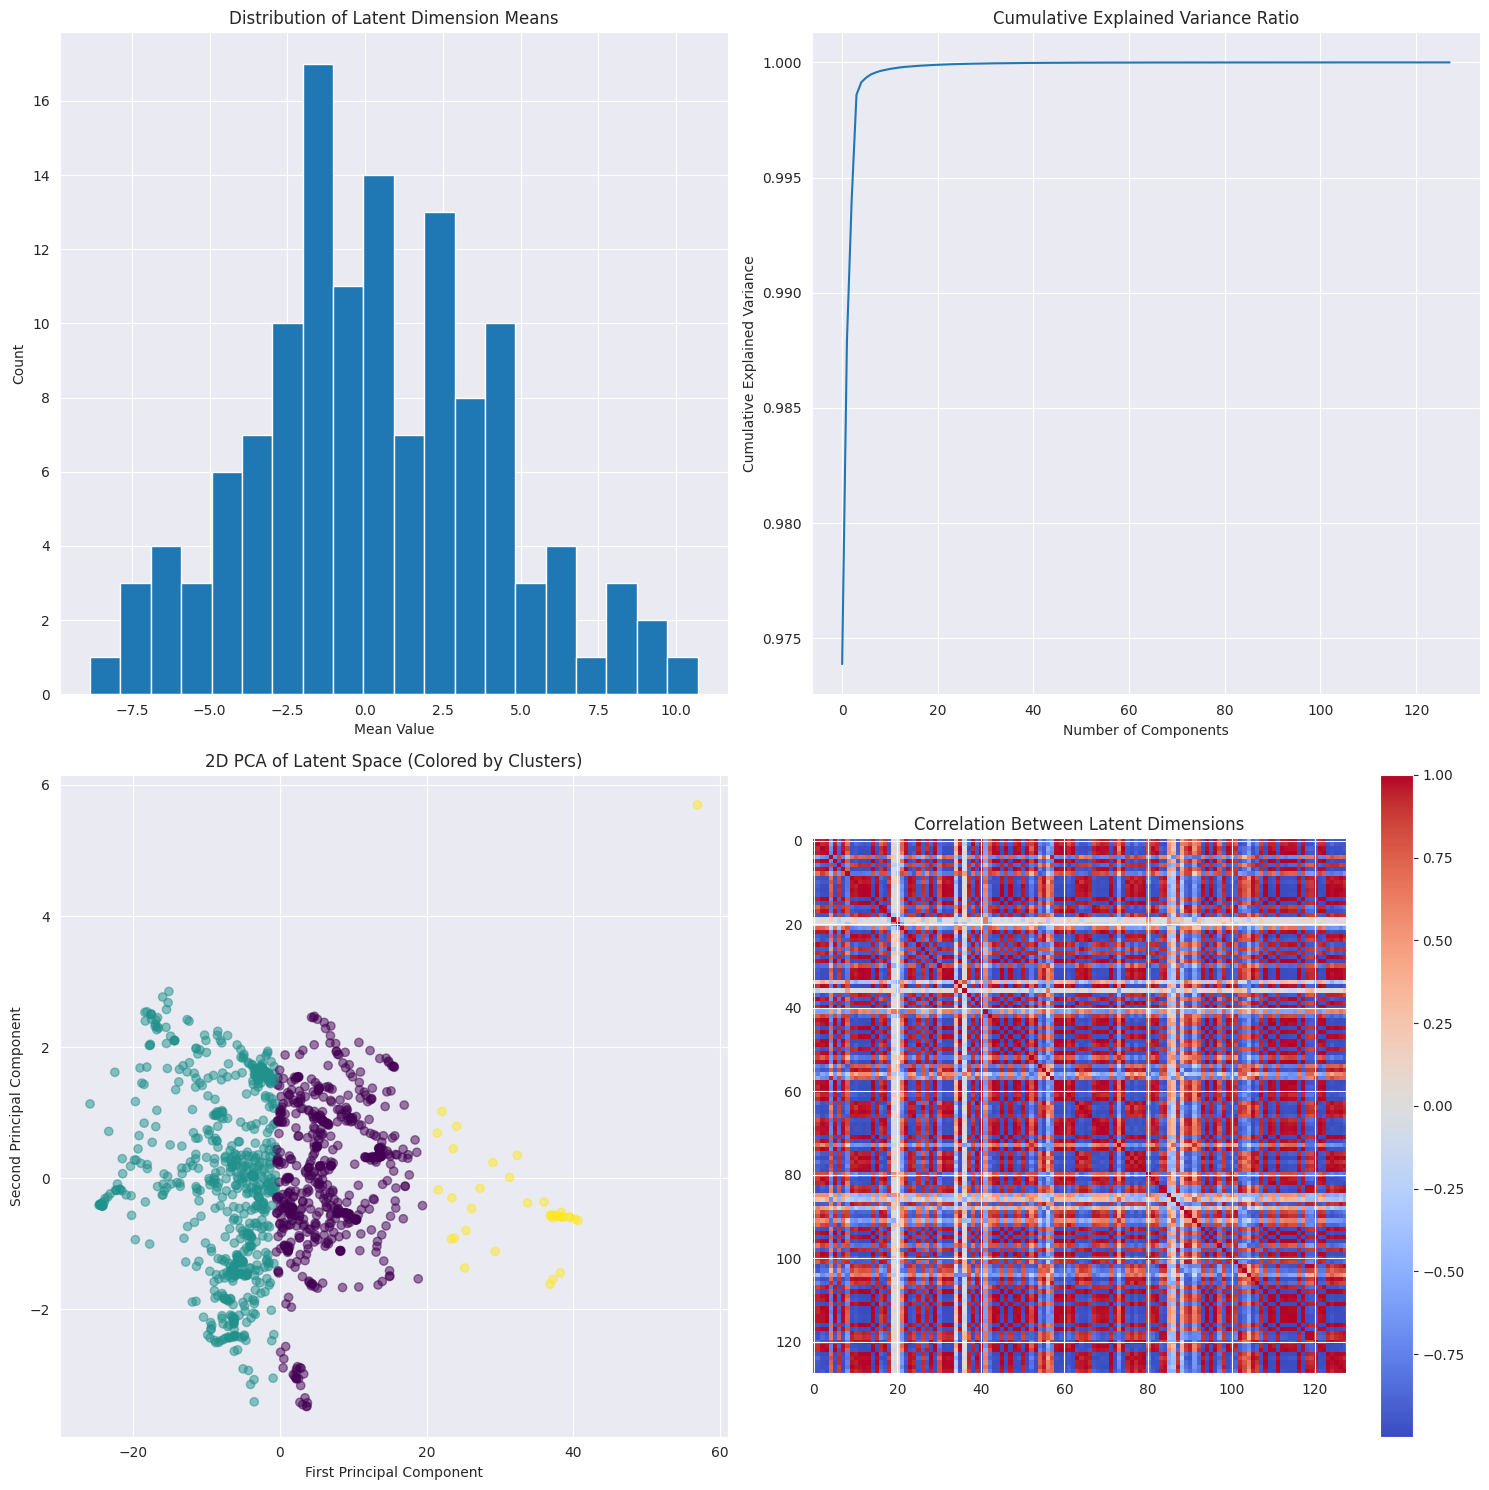

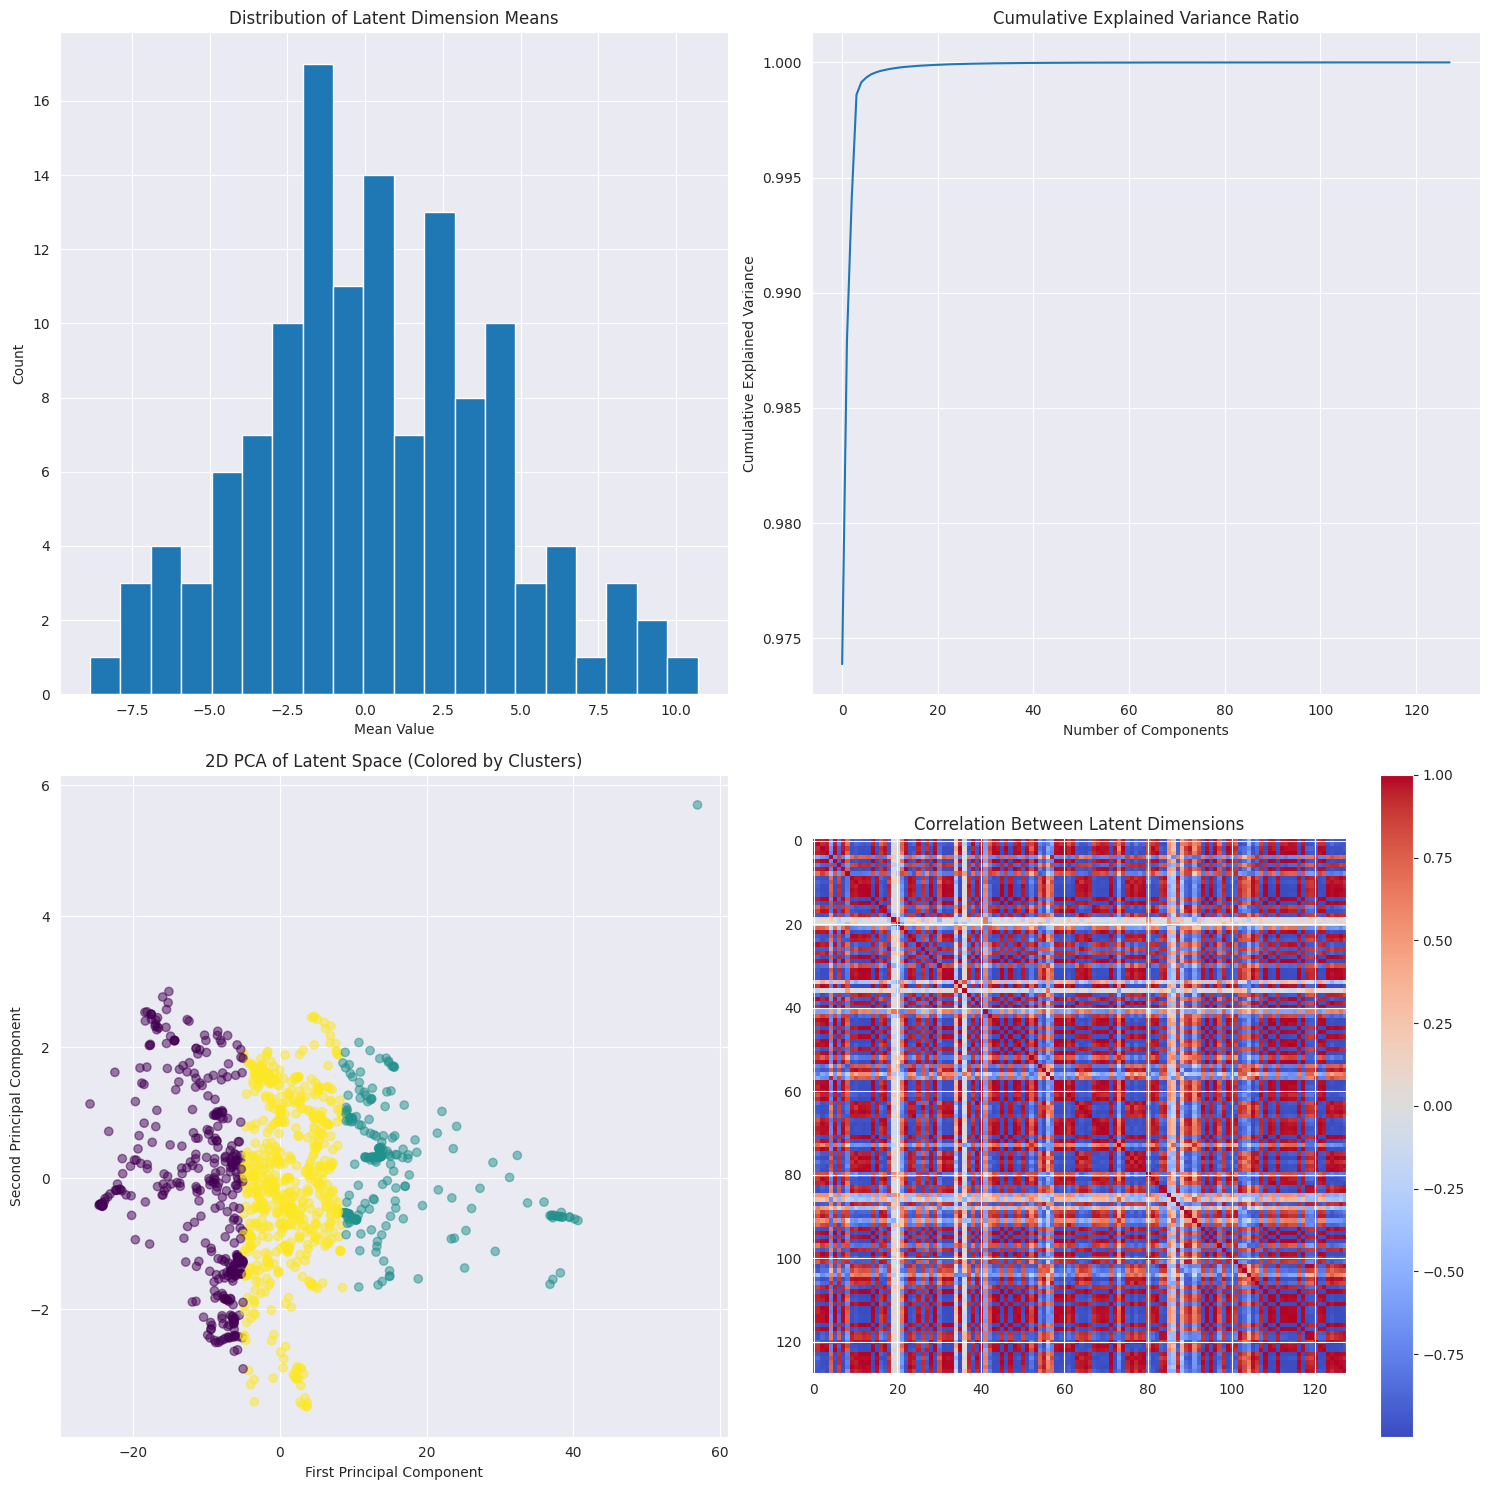

In [26]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


def extract_latent_representations(model, dataloader, device):
    model.eval()
    all_mus = []
    all_actions = []
    
    with torch.no_grad():
        for batch in dataloader:
            # Get inputs
            x_img = batch.input["images"].to(device)
            x_num = batch.input["obs"].to(device)
            
            # Get actions for analysis
            actions = batch.output["actions"] if "actions" in batch.output else None
            
            # Get latent representations (mu)
            mu, _ = model.encode(x_img, x_num)
            
            # Store results
            all_mus.append(mu.cpu().numpy())
            if actions is not None:
                all_actions.append(actions.cpu().numpy())
    
    # Concatenate all batches
    all_mus = np.concatenate(all_mus, axis=0)
    all_actions = np.concatenate(all_actions, axis=0) if actions is not None else None
    
    return all_mus, all_actions

# Extract latent representations
latent_reps, actions = extract_latent_representations(vae_model, train_dataloader, device)

# Now let's analyze the latent space
def analyze_latent_space_properties(latent_reps):
    """Analyze various properties of the latent space"""
    
    # 1. Distribution Analysis
    mean_per_dim = np.mean(latent_reps, axis=0)
    std_per_dim = np.std(latent_reps, axis=0)
    
    # 2. Dimensionality Analysis
    pca = PCA()
    pca.fit(latent_reps)
    explained_variance_ratio = pca.explained_variance_ratio_
    
    # 3. Clustering Analysis
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(latent_reps)
    
    # 4. Visualize first two principal components
    pca_2d = PCA(n_components=2)
    latent_2d = pca_2d.fit_transform(latent_reps)
    
    # Create visualization plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    # Plot distributions
    axes[0,0].hist(mean_per_dim, bins=20)
    axes[0,0].set_title('Distribution of Latent Dimension Means')
    axes[0,0].set_xlabel('Mean Value')
    axes[0,0].set_ylabel('Count')
    
    # Plot explained variance
    axes[0,1].plot(np.cumsum(explained_variance_ratio))
    axes[0,1].set_title('Cumulative Explained Variance Ratio')
    axes[0,1].set_xlabel('Number of Components')
    axes[0,1].set_ylabel('Cumulative Explained Variance')
    
    # Plot 2D PCA
    scatter = axes[1,0].scatter(latent_2d[:, 0], latent_2d[:, 1], 
                               c=clusters, cmap='viridis', alpha=0.5)
    axes[1,0].set_title('2D PCA of Latent Space (Colored by Clusters)')
    axes[1,0].set_xlabel('First Principal Component')
    axes[1,0].set_ylabel('Second Principal Component')
    
    # Plot correlation heatmap
    correlation_matrix = np.corrcoef(latent_reps.T)
    im = axes[1,1].imshow(correlation_matrix, cmap='coolwarm')
    axes[1,1].set_title('Correlation Between Latent Dimensions')
    plt.colorbar(im, ax=axes[1,1])
    
    plt.tight_layout()
    plt.show()
    
    return {
        'mean_per_dim': mean_per_dim,
        'std_per_dim': std_per_dim,
        'explained_variance_ratio': explained_variance_ratio,
        'clusters': clusters
    }

# Run analysis
analysis_results = analyze_latent_space_properties(latent_reps)

def extract_latent_representations(model, dataloader, device):
    model.eval()
    all_mus = []
    all_actions = []
    
    with torch.no_grad():
        for batch in dataloader:
            # Get inputs
            x_img = batch.input["images"].to(device)
            x_num = batch.input["obs"].to(device)
            
            # Get actions for analysis
            actions = batch.output["actions"] if "actions" in batch.output else None
            
            # Get latent representations (mu)
            mu, _ = model.encode(x_img, x_num)
            
            # Store results
            all_mus.append(mu.cpu().numpy())
            if actions is not None:
                all_actions.append(actions.cpu().numpy())
    
    # Concatenate all batches
    all_mus = np.concatenate(all_mus, axis=0)
    all_actions = np.concatenate(all_actions, axis=0) if actions is not None else None
    
    return all_mus, all_actions

# Extract latent representations
latent_reps, actions = extract_latent_representations(vae_model, train_dataloader, device)

# Now let's analyze the latent space
def analyze_latent_space_properties(latent_reps):
    """Analyze various properties of the latent space"""
    
    # 1. Distribution Analysis
    mean_per_dim = np.mean(latent_reps, axis=0)
    std_per_dim = np.std(latent_reps, axis=0)
    
    # 2. Dimensionality Analysis
    pca = PCA()
    pca.fit(latent_reps)
    explained_variance_ratio = pca.explained_variance_ratio_
    
    # 3. Clustering Analysis
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(latent_reps)
    
    # 4. Visualize first two principal components
    pca_2d = PCA(n_components=2)
    latent_2d = pca_2d.fit_transform(latent_reps)
    
    # Create visualization plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    # Plot distributions
    axes[0,0].hist(mean_per_dim, bins=20)
    axes[0,0].set_title('Distribution of Latent Dimension Means')
    axes[0,0].set_xlabel('Mean Value')
    axes[0,0].set_ylabel('Count')
    
    # Plot explained variance
    axes[0,1].plot(np.cumsum(explained_variance_ratio))
    axes[0,1].set_title('Cumulative Explained Variance Ratio')
    axes[0,1].set_xlabel('Number of Components')
    axes[0,1].set_ylabel('Cumulative Explained Variance')
    
    # Plot 2D PCA
    scatter = axes[1,0].scatter(latent_2d[:, 0], latent_2d[:, 1], 
                               c=clusters, cmap='viridis', alpha=0.5)
    axes[1,0].set_title('2D PCA of Latent Space (Colored by Clusters)')
    axes[1,0].set_xlabel('First Principal Component')
    axes[1,0].set_ylabel('Second Principal Component')
    
    # Plot correlation heatmap
    correlation_matrix = np.corrcoef(latent_reps.T)
    im = axes[1,1].imshow(correlation_matrix, cmap='coolwarm')
    axes[1,1].set_title('Correlation Between Latent Dimensions')
    plt.colorbar(im, ax=axes[1,1])
    
    plt.tight_layout()
    # plt.show()
    
    return {
        'mean_per_dim': mean_per_dim,
        'std_per_dim': std_per_dim,
        'explained_variance_ratio': explained_variance_ratio,
        'clusters': clusters
    }

# Run analysis
analysis_results = analyze_latent_space_properties(latent_reps)

$ \text{Latent Space Analysis} $
$ \text{1. PCA of Latent Space: Ideally our latent space should roughly resemble a 2D Normal distribution (that is, a spherical distribution). More than being spherical, our latent space should be smooth, continuous, and free of any big gaps. It should preserve features of the downstreak task.} $

## Question 3 Full model training
This question requires you to first develop a supervised head which utilises the latent space from your self-supervised method. You are then required to assess the models performance as well as the model you developed in question 1.c.i on the test set, report the performance and conclude whether self-supervised learning is appropriate for this task.

### Question 3.a Combining self-supervised model with the downstream task (5 marks)

##### Task
- Develop a model which combines the self-supervised pretraining with a model for performing the downstream task by freezing the self-supervised model and fine-tuning a head for prediction and implement it in the code block below. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions). The supervised head should at least include any inputs that you did not feed into the self-supervised model. For example, assume you decide to perform self-supervised learning only using front_cam_ob images. You must also include mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob and joint_pos_ob observations in your model.

In [27]:
# ******* INSERT YOUR CODE HERE *******


# ******* INSERT YOUR CODE HERE - END *******

### Question 3.b Assessing the suitability of self-supervised learning 
For the final two questions, you are required to assess the performance of the self-supervised + supervised head model and the end-to-end model that you have trained. Additionally, you are required to holistically evaluate whether self-supervised learning has been beneficial for this task.

#### Question 3.b.i Assessing the suitability of self-supervised learning (4 marks) 

##### Task
- In the code block below, evaluate the performance of the model you trained in question 3.a and the model you trained in question 1.c.i, using the test set. Additionally use the same metrics to train and evaluate the model that you used for question 1.c.i. Markers should be able to run the cell such that both models are run on the appropriate dataset. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

In [28]:
# ******* INSERT YOUR CODE HERE *******


# ******* INSERT YOUR CODE HERE - END *******

#### Question 3.b.ii Justification (5 marks)

##### Task
- Conclude whether the self-supervised pre-training was beneficial for the task of predicting actions. Your answer should not solely focus on final performance but rather be nuianced and balance other model development considerations for example parameter count and speed of convergence. Also, if you believe the comparison between the model trained in question 3.a.i aganst the model trained in question 2.c.i is not _fair_, discuss further experiments which you would perform to reduce the bias in your conclusions. Provide __empirical evidence__ to support your conclusions. __0 marks__ will be awarded if empirical evidence is __not__ provided.